https://www.kaggle.com/c/jds3

In [ ]:
!pip install --no-cache-dir scikit-learn==1.0

Импортируем библиотеки

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import datetime
import random
import time
import copy
import string

In [ ]:
from sklearn import metrics
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

from sklearn.model_selection._search_successive_halving import HalvingGridSearchCV, HalvingRandomSearchCV

In [ ]:
from xgboost import XGBClassifier

Отключаем ошибки

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Устанавливаем начальные параметры

In [ ]:
rnd = 247

In [ ]:
n_cmp = 53
folds = 3
metric = 'accuracy'
pr = 0.9

Читаем и обрабатываем исходные данные

In [ ]:
data = pd.read_csv("emnist-letters-train.csv").fillna(0).values

In [ ]:
data.shape

(88799, 785)

In [ ]:
X = data[:,1:]
y = data[:,0]

d


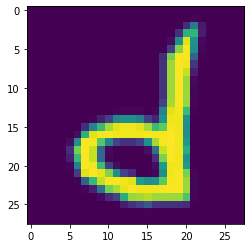

In [ ]:
alphabet = list(string.ascii_lowercase)
idx =np.random.randint(0,88000)
print(alphabet[y[idx]-1])
plt.imshow(X[idx].reshape(28,28).T)

Проведем кластеризацию данных

In [ ]:
kmeans = KMeans(n_clusters=len(np.unique(y)), random_state=rnd).fit(X)
X = np.append(X, kmeans.labels_[:, np.newaxis], axis=1)

Снизим размерность данных

In [ ]:
X_ch, _, _, _ = train_test_split(X, y, test_size=0.85, random_state=rnd)
pca = KernelPCA(n_components=n_cmp, random_state=rnd, kernel="cosine", n_jobs=-1)
pca.fit(X_ch)
X2 = pca.transform(X)

Разобьем обработанные данные на тренировочную и тестовую выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.20, random_state=rnd)

In [ ]:
# Был эксперимент по стандартизации данных. Однако по факту после преобразования результаты 
# не улучшились, а временные затраты существенно возросли, поэтому пропустим.
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train_scaled = sc.fit_transform(X_train)

Создадим первоначальный список моделей и обучим их на кросс-валидации

In [ ]:
models = {}
models['LogisticRegression'] = LogisticRegression(multi_class='multinomial', random_state=rnd)
models['BernoulliNB'] = BernoulliNB()
models['DecisionTreeClassifier'] = DecisionTreeClassifier(random_state=rnd)
models['LinearSVC'] = LinearSVC(random_state=rnd)
models['SVC'] = SVC(random_state=rnd)
models['KNeighborsClassifier'] = KNeighborsClassifier()
models['RandomForestClassifier'] = RandomForestClassifier(random_state=rnd)
models['SGDClassifier'] = SGDClassifier(random_state=rnd)
models['RidgeClassifier'] = RidgeClassifier(random_state=rnd)
models['GradientBoostingClassifier'] = GradientBoostingClassifier(random_state=rnd) # Считается несколько часов, поэтому пропустим, полученный скор - 0.7497, 0.7502
models['AdaBoostClassifier'] = AdaBoostClassifier(random_state=rnd)
models['XGBClassifier'] = XGBClassifier(random_state=rnd)

In [ ]:
k_fold = KFold(n_splits=folds)

In [ ]:
def CallModel(name, model):
    start_time = time.time()
    k_fold = KFold(n_splits=folds)
    res = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=metric, n_jobs=-1)
    results.append([name, model, res.mean(), time.time() - start_time])
    print(results[-1])

In [ ]:
results = list()
for name in models:
    CallModel(name, models[name])

['LogisticRegression', LogisticRegression(multi_class='multinomial', random_state=247), 0.6829769306316958, 7.53308629989624]
['BernoulliNB', BernoulliNB(), 0.4960374214008764, 0.7488369941711426]
['DecisionTreeClassifier', DecisionTreeClassifier(random_state=247), 0.6052590652463562, 5.766408443450928]
['LinearSVC', LinearSVC(random_state=247), 0.6680133490103559, 5.698237180709839]
['SVC', SVC(random_state=247), 0.902377569392844, 128.90127396583557]
['KNeighborsClassifier', KNeighborsClassifier(), 0.8735483244314249, 23.341524124145508]
['RandomForestClassifier', RandomForestClassifier(random_state=247), 0.836878376975417, 38.90308713912964]
['SGDClassifier', SGDClassifier(random_state=247), 0.6251074305729142, 2.0463178157806396]
['RidgeClassifier', RidgeClassifier(random_state=247), 0.5682230946977004, 0.33173441886901855]
['GradientBoostingClassifier', GradientBoostingClassifier(random_state=247), 0.7524599208434966, 1970.6136853694916]
['AdaBoostClassifier', AdaBoostClassifier(r

Видим, что наилучшие результаты у SVC, поэтому далее будем продолжать работать именно с данной моделью

In [ ]:
for kernel in ("linear", "poly", "rbf", "sigmoid"):
    CallModel(f'SVC - {kernel}', SVC(kernel=kernel, random_state=rnd))

['SVC - linear', SVC(kernel='linear', random_state=247), 0.7729275836079332, 92.0339584350586]
['SVC - poly', SVC(kernel='poly', random_state=247), 0.907374838492997, 97.55663633346558]
['SVC - rbf', SVC(random_state=247), 0.902377569392844, 126.53667163848877]
['SVC - sigmoid', SVC(kernel='sigmoid', random_state=247), 0.5215163204586191, 114.73875045776367]


Поскольку лучшие результаты получились у полиномиальной модели и модели с использованием радиально-базисных функций, далее протестируем их

In [ ]:
for degree in range(2, 6):
    CallModel(f'SVC - poly - degree-{degree}', SVC(kernel='poly', degree=degree, random_state=rnd))

['SVC - poly - degree-2', SVC(degree=2, kernel='poly', random_state=247), 0.9009276748717551, 78.22455596923828]
['SVC - poly - degree-3', SVC(kernel='poly', random_state=247), 0.907374838492997, 96.18978571891785]
['SVC - poly - degree-4', SVC(degree=4, kernel='poly', random_state=247), 0.9038415678363654, 125.90988540649414]
['SVC - poly - degree-5', SVC(degree=5, kernel='poly', random_state=247), 0.8918340732408577, 149.62631273269653]


In [ ]:
for C in np.arange(3, 7):
    CallModel(f'SVC - rbf - C-{C}', SVC(kernel='rbf', C=C, random_state=rnd))

['SVC - rbf - C-3', SVC(C=3, random_state=247), 0.9123298695407684, 120.95994091033936]
['SVC - rbf - C-4', SVC(C=4, random_state=247), 0.9131603964759134, 121.87320184707642]
['SVC - rbf - C-5', SVC(C=5, random_state=247), 0.9133293165837827, 121.65688443183899]
['SVC - rbf - C-6', SVC(C=6, random_state=247), 0.9132448577187983, 121.55361199378967]


Посмотрим полученный результат после обучения моделей

In [ ]:
df_results = pd.DataFrame(results, columns=('Name', 'Model', 'Score', 'Time')).sort_values(by=['Score', 'Time'], ascending=[False, True])
df_results[df_results.Score>=pr]

,Name,Model,Score,Time
22,SVC - rbf - C-5,"SVC(C=5, random_state=247)",0.913329,121.656884
23,SVC - rbf - C-6,"SVC(C=6, random_state=247)",0.913245,121.553612
21,SVC - rbf - C-4,"SVC(C=4, random_state=247)",0.913160,121.873202
20,SVC - rbf - C-3,"SVC(C=3, random_state=247)",0.912330,120.959941
17,SVC - poly - degree-3,"SVC(kernel='poly', random_state=247)",0.907375,96.189786
13,SVC - poly,"SVC(kernel='poly', random_state=247)",0.907375,97.556636
18,SVC - poly - degree-4,"SVC(degree=4, kernel='poly', random_state=247)",0.903842,125.909885
14,SVC - rbf,SVC(random_state=247),0.902378,126.536672
4,SVC,SVC(random_state=247),0.902378,128.901274
16,SVC - poly - degree-2,"SVC(degree=2, kernel='poly', random_state=247)",0.900928,78.224556


Проведем поиск лучших параметров по лучшим моделям SVM с помощью поиска по сетке

In [ ]:
params_svc = {'C': np.arange(0.5, 10.5, 0.5),   
              'kernel': ['rbf', 'poly'], 
              'degree': np.arange(2, 6, 0.5),
              'decision_function_shape': ('ovo', 'ovr'),
              'gamma': ['scale'],
              'cache_size': [1000],
              'shrinking': [False, True],
              'class_weight': ['balanced', None],
              'random_state': [rnd, 32]}

In [ ]:
start_time = time.time()
grid_svc = HalvingRandomSearchCV(df_results.iloc[0].Model, params_svc, cv=4, factor=3, verbose=0, scoring='accuracy', random_state=rnd, n_jobs=-1).fit(X2, y)
svc_gs = SVC(**grid_svc.best_params_).fit(X_train, y_train)
acc = metrics.accuracy_score(svc_gs.predict(X_test), y_test)
results.append([f'HalvingRandomSearchCV - {df_results.iloc[0].Model}', grid_svc, acc, time.time() - start_time]) #time.time() - start_time
print(results[-1])

['HalvingRandomSearchCV - SVC(C=5, random_state=247)', HalvingRandomSearchCV(cv=4, estimator=SVC(C=5, random_state=247), n_jobs=-1,
                      param_distributions={'C': array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
                                           'cache_size': [1000],
                                           'class_weight': ['balanced', None],
                                           'decision_function_shape': ('ovo',
                                                                       'ovr'),
                                           'degree': array([2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5]),
                                           'gamma': ['scale'],
                                           'kernel': ['rbf', 'poly'],
                                           'random_state': [247, 32],
                                           'shrinking': [False, True]},
      

Результат несколько улучшился. Посмотрим на наилучшие параметры модели:

In [ ]:
print(grid_svc.best_params_)

{'shrinking': False, 'random_state': 247, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 5.5, 'decision_function_shape': 'ovo', 'class_weight': None, 'cache_size': 1000, 'C': 6.5}


Построим голосующий классификатор

In [ ]:
estimators, weights = list(), list()
for i in range(len(results)):
    if results[i][2]>pr and (results[i][0][:21]!='HalvingRandomSearchCV'):
        estimators.append((results[i][0], results[i][1]))
        weights.append(round((results[i][2] - pr)*100, 1))
estimators, weights

([('SVC', SVC(random_state=247)),
  ('SVC - poly', SVC(kernel='poly', random_state=247)),
  ('SVC - rbf', SVC(random_state=247)),
  ('SVC - poly - degree-2', SVC(degree=2, kernel='poly', random_state=247)),
  ('SVC - poly - degree-3', SVC(kernel='poly', random_state=247)),
  ('SVC - poly - degree-4', SVC(degree=4, kernel='poly', random_state=247)),
  ('SVC - rbf - C-3', SVC(C=3, random_state=247)),
  ('SVC - rbf - C-4', SVC(C=4, random_state=247)),
  ('SVC - rbf - C-5', SVC(C=5, random_state=247)),
  ('SVC - rbf - C-6', SVC(C=6, random_state=247))],
 [0.2, 0.7, 0.2, 0.1, 0.7, 0.4, 1.2, 1.3, 1.3, 1.3])

In [ ]:
est = copy.deepcopy(estimators)
estimators = {'hard': copy.deepcopy(estimators)}
for i in range(len(est)):
    est[i][1].set_params(**{'probability': True})
estimators['soft'] = est
print(estimators)

{'hard': [('SVC', SVC(random_state=247)), ('SVC - poly', SVC(kernel='poly', random_state=247)), ('SVC - rbf', SVC(random_state=247)), ('SVC - poly - degree-2', SVC(degree=2, kernel='poly', random_state=247)), ('SVC - poly - degree-3', SVC(kernel='poly', random_state=247)), ('SVC - poly - degree-4', SVC(degree=4, kernel='poly', random_state=247)), ('SVC - rbf - C-3', SVC(C=3, random_state=247)), ('SVC - rbf - C-4', SVC(C=4, random_state=247)), ('SVC - rbf - C-5', SVC(C=5, random_state=247)), ('SVC - rbf - C-6', SVC(C=6, random_state=247))], 'soft': [('SVC', SVC(probability=True, random_state=247)), ('SVC - poly', SVC(kernel='poly', probability=True, random_state=247)), ('SVC - rbf', SVC(probability=True, random_state=247)), ('SVC - poly - degree-2', SVC(degree=2, kernel='poly', probability=True, random_state=247)), ('SVC - poly - degree-3', SVC(kernel='poly', probability=True, random_state=247)), ('SVC - poly - degree-4', SVC(degree=4, kernel='poly', probability=True, random_state=247))

In [ ]:
for type in ['hard', 'soft']:
    start_time = time.time()
    voting_clf = VotingClassifier(estimators=estimators[type], weights=weights, voting=type, n_jobs=-1)
    voting_clf.fit(X_train, y_train)
    acc = metrics.accuracy_score(y_test, voting_clf.predict(X_test))
    results.append([f'VotingClassifier - {type}', voting_clf, acc, time.time() - start_time])
    print(results[-1])

['VotingClassifier - hard', VotingClassifier(estimators=[('SVC', SVC(random_state=247)),
                             ('SVC - poly',
                              SVC(kernel='poly', random_state=247)),
                             ('SVC - rbf', SVC(random_state=247)),
                             ('SVC - poly - degree-2',
                              SVC(degree=2, kernel='poly', random_state=247)),
                             ('SVC - poly - degree-3',
                              SVC(kernel='poly', random_state=247)),
                             ('SVC - poly - degree-4',
                              SVC(degree=4, kernel='poly', random_state=247)),
                             ('SVC - rbf - C-3', SVC(C=3, random_state=247)),
                             ('SVC - rbf - C-4', SVC(C=4, random_state=247)),
                             ('SVC - rbf - C-5', SVC(C=5, random_state=247)),
                             ('SVC - rbf - C-6', SVC(C=6, random_state=247))],
                 n_jobs=-1

Посмотрим лучшие результаты обучения моделей и сохраним результаты в файл

In [ ]:
df_results = pd.DataFrame(results, columns=('Name', 'Model', 'Score', 'Time')).sort_values(by=['Score', 'Time'], ascending=[False, True])
df_results.to_csv('model-results.csv')
df_results[df_results.Score>=0.9]

,Name,Model,Score,Time
26,VotingClassifier - soft,"VotingClassifier(estimators=[('SVC', SVC(proba...",0.927252,2067.414193
25,VotingClassifier - hard,"VotingClassifier(estimators=[('SVC', SVC(rando...",0.925450,818.872520
24,"HalvingRandomSearchCV - SVC(C=5, random_state=...","HalvingRandomSearchCV(cv=4, estimator=SVC(C=5,...",0.925000,912.341701
22,SVC - rbf - C-5,"SVC(C=5, random_state=247)",0.913329,121.656884
23,SVC - rbf - C-6,"SVC(C=6, random_state=247)",0.913245,121.553612
21,SVC - rbf - C-4,"SVC(C=4, random_state=247)",0.913160,121.873202
20,SVC - rbf - C-3,"SVC(C=3, random_state=247)",0.912330,120.959941
17,SVC - poly - degree-3,"SVC(kernel='poly', random_state=247)",0.907375,96.189786
13,SVC - poly,"SVC(kernel='poly', random_state=247)",0.907375,97.556636
18,SVC - poly - degree-4,"SVC(degree=4, kernel='poly', random_state=247)",0.903842,125.909885


Сделаем предсказание на лучшей модели - голосующем классификаторе с мягким голосованием, для чего повторно в начале обучим ее на полной выборке, и сохраним итоговый результат в файл (который и направим на конкурс)

In [ ]:
model = df_results.iloc[0].Model
model = model.fit(X2, y)

In [ ]:
def save_result(model, file_name):
    X_res = pd.read_csv("emnist-letters-test-sh.csv", header=None).fillna(0).values
    labels = kmeans.predict(X_res)
    X_res = np.append(X_res, labels[:, np.newaxis], axis=1)
    X_res = pca.transform(X_res)
    y_pred = model.predict(X_res)
    df = pd.DataFrame(y_pred, columns=["Category"])
    df.index += 1
    pd.DataFrame(df).to_csv(file_name, index_label="Id")
    print(pd.read_csv(file_name)[:10])

In [ ]:
save_result(model, 'prediction.csv')

   Id  Category
0   1        12
1   2        14
2   3        10
3   4        15
4   5        12
5   6         1
6   7         1
7   8        18
8   9         3
9  10        17


Таким образом, мы осуществили следующий порядок действий:
- прочитали данные;
- применили KMeand для кластеризации данных и добавили в данные новый признак - получившийся класс;
- с помощью KernelPCA с косинусным ядром снизили размерность;
- обучили набор моделей;
- на основании лучших моделей построили голосующий классификатор;
- к лучшему типу модели применили поиск параметров по сетке;
- прочитали тестовые данные;
- на основании полученных параметров сделали кластеризацию искомых данных и сохранили их в файл.